In [10]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import keras
from keras import layers
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import tqdm
import pandas as pd

In [2]:
# hyper-parameters
ROOT_FOLDER = "..\.."
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
TRAIN_FOLDER = os.path.join(DATA_FOLDER, "train_set")
TEST_FOLDER = os.path.join(DATA_FOLDER, "test_set")
PROCESSED_DATA = os.path.join(ROOT_FOLDER, 'processed_data')
TEMPLATE_FOLDER = os.path.join(PROCESSED_DATA, 'templates')

In [3]:
def create_dataset(processed_data=True, train=True, anomaly=False):
    """
    gather all files from all folders in the train or test folder

    :type: str representing which files we want
    :return: list containing
    """

    # define whether to use train or test set
    if train:
        data_set = 'train_set'
    else:
        data_set = 'test_set'

    # define whether to use processed or original data
    if processed_data:
        data_folder = PROCESSED_DATA
        templates = [1,2,3,4,5,6]
    else:
        data_folder = DATA_FOLDER
        template_folder = os.path.join(DATA_FOLDER, data_set)
        templates = os.listdir(template_folder)

    # choose anomalous dice if set as parameter
    if anomaly:
        templates = ["ano"]

    # initialize return types
    data = []
    label = []

    for template in templates:
        # get the folder name, all filenames inside it, and make a list of all the image files inside
        train_folder = os.path.join(data_folder, data_set)
        folder = os.path.join(train_folder, str(template))
        filenames = os.listdir(folder)
        files = [file for file in filenames if ".png" in file]

        for file in files:
            img = Image.open(os.path.join(folder,file))
            data.append(np.array(img))
            label.append(template)
            
    label= np.array(label).reshape(-1,1)

    return data, label


In [4]:
def SSIMLoss(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [5]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return tf.reduce_mean(-np.mean(term_0+term_1, axis=0))

In [6]:
def split_and_preprocess_dataset(data, split = True):
    data = np.array(data)
    preprocessed_data = data/255
    preprocessed_data = np.expand_dims(preprocessed_data, axis=3)

    if not split:
        return preprocessed_data, _, _, _, _, _, _, _

    # split data in train/val/test set
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        preprocessed_data, 
        labels,
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, 
        train_val_labels,
        test_size=0.3, 
        random_state=42, 
        shuffle=True
    )

    return train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels

In [7]:
# gather, process and preprocess all training data.

data, labels = create_dataset(processed_data=True, train=True)
train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels = split_and_preprocess_dataset(data)

In [8]:
# gather, process and preprocess all training data.

anomalies, _ = create_dataset(processed_data=True, train=True, anomaly=True)
anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(anomalies, split = False)
#anomalies = [x.reshape(128, 128, 1) for x in anomalies]

In [9]:
# gather the unseen testing data set

test_normals, _ = create_dataset(processed_data=True, train=False, anomaly=False)
test_normals, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_normals, split = False)

test_anomalies, _ = create_dataset(processed_data=True, train=False, anomaly=True)
test_anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_anomalies, split = False)

In [10]:
# build model

# input size is (128, 128). That means the input is 16.384 floats. In the input below they have an input of 784.
input_shape = (128, 128, 1)

"""
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
"""

inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')

encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)

decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)

outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


history = autoencoder.fit(train_data[:500], train_data[:500],
                epochs=10,
                batch_size=10,
                shuffle=True,
                validation_data=(val_data[:500], val_data[:500]),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 128, 128, 64)     18496     
 nspose)                                                         
                                                                 
 conv_transpose_4 (Conv2DTra  (None, 128, 128, 1)      577       
 nspose)                                                         
                                                                 
Total params: 19,393
Trainable params: 19,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


C:\Users\aubin\anaconda3\envs\dicething\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/50 [==============================] - 21s 409ms/step - loss: 0.3873 - val_loss: 0.3491
Epoch 2/10
50/50 [==============================] - 25s 506ms/step - loss: 0.3177 - val_loss: 0.3057
Epoch 3/10
50/50 [==============================] - 25s 496ms/step - loss: 0.3036 - val_loss: 0.3022
Epoch 4/10
50/50 [==============================] - 22s 449ms/step - loss: 0.3011 - val_loss: 0.3001
Epoch 5/10
50/50 [==============================] - 26s 516ms/step - loss: 0.2993 - val_loss: 0.2988
Epoch 6/10
50/50 [==============================] - 28s 574ms/step - loss: 0.2983 - val_loss: 0.2980
Epoch 7/10
50/50 [==============================] - 20s 410ms/step - loss: 0.2976 - val_loss: 0.2976
Epoch 8/10
50/50 [==============================] - 24s 476ms/step - loss: 0.2974 - val_loss: 0.2976
Epoch 9/10
50/50 [==============================] - 25s 500ms/step - loss: 0.2972 - val_loss: 0.2971
Epoch 10/10
50/50 [==============================] - 21s 428ms/step - loss: 0.2968 - val_loss: 0.2969


In [11]:
autoencoder.save('../../models/v1-1.h5')

In [11]:
autoencoder = tf.keras.models.load_model('../../models/v1-1.h5')

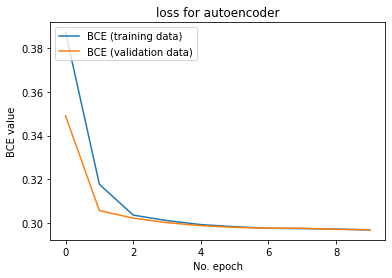

In [13]:
# Plot history: loss
plt.plot(history.history['loss'], label='BCE (training data)')
plt.plot(history.history['val_loss'], label='BCE (validation data)')
plt.title('loss for autoencoder')
plt.ylabel('BCE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

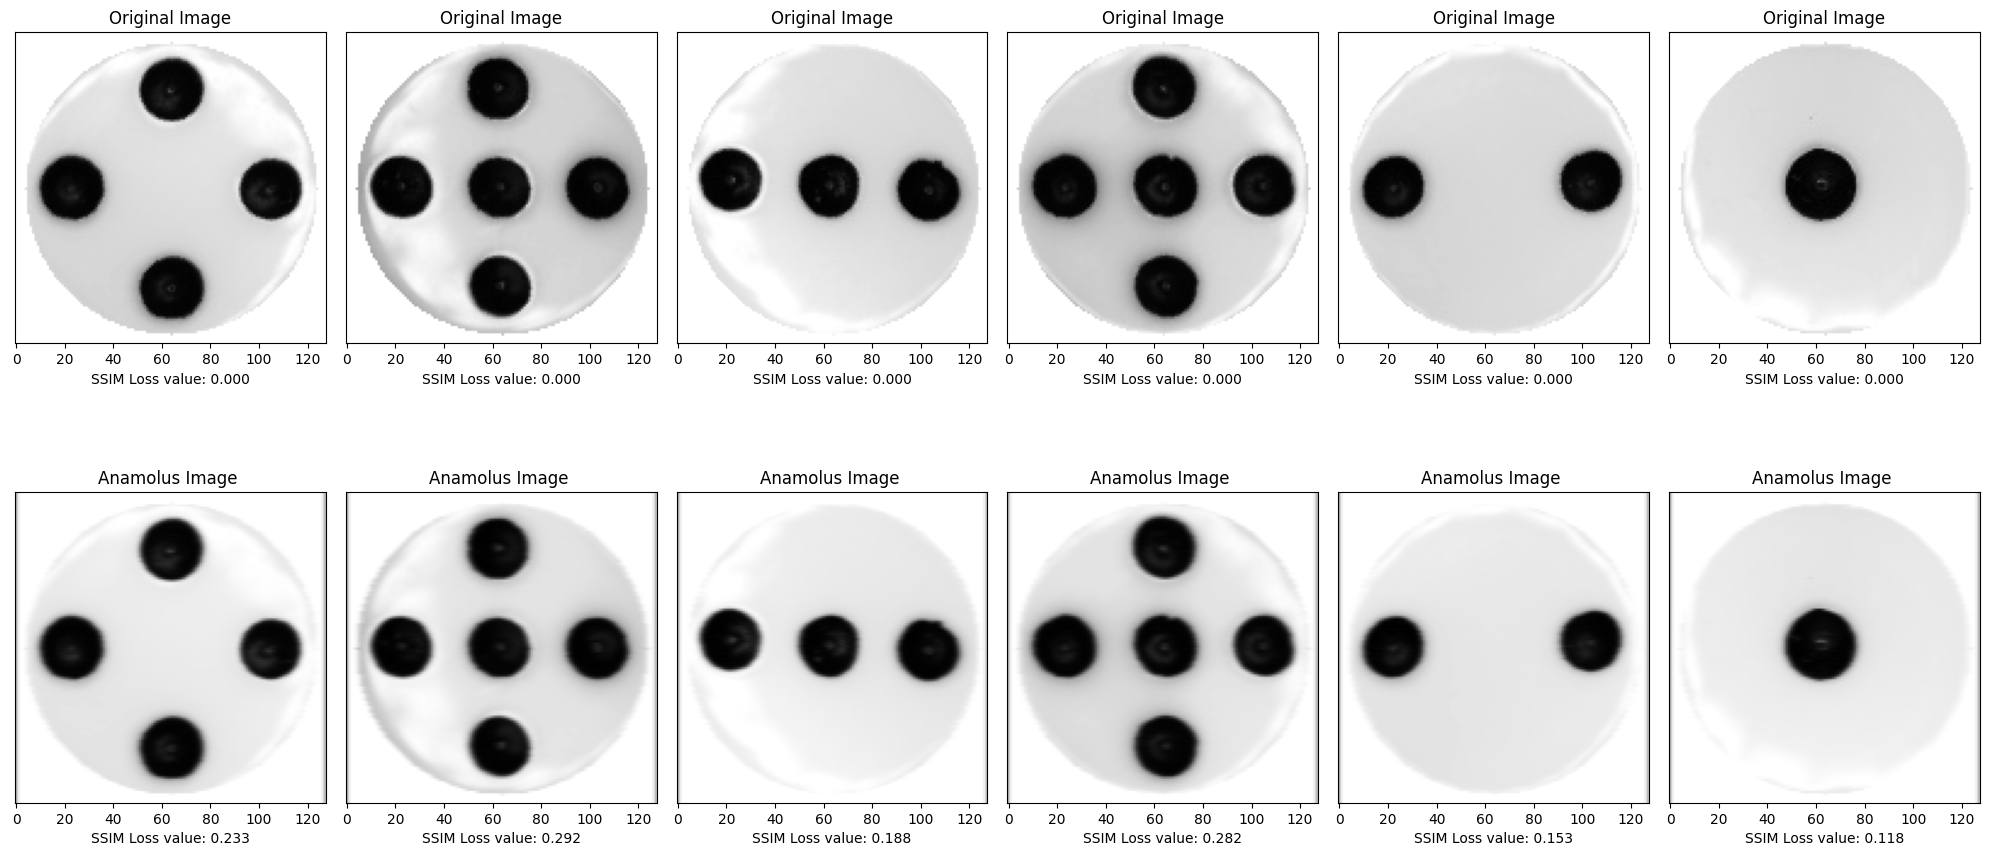

In [14]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):

    decoded_imgs.append(autoencoder.predict(test_data[i]))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_imgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

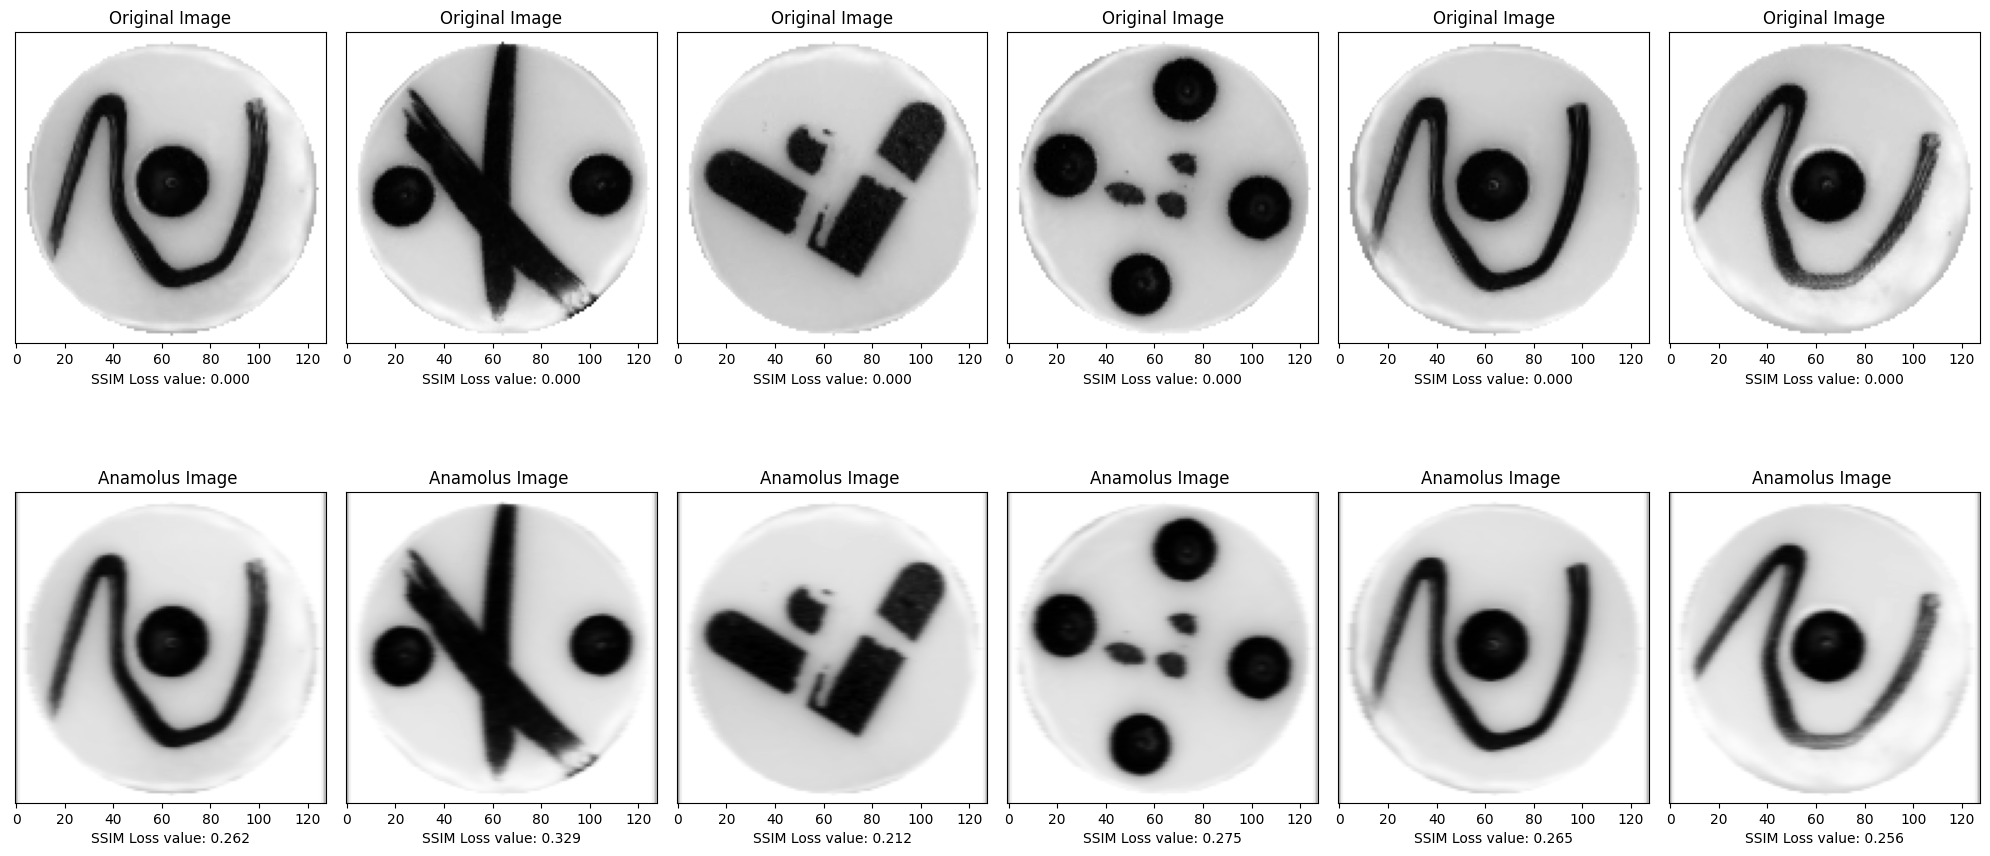

In [15]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):

    decoded_mnistimgs.append(autoencoder.predict(anomalies[i]))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(anomalies[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(anomalies[i], anomalies[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_mnistimgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, anomalies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

In [16]:
# evaluate

In [12]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = []
  errors = []
  for x in x_test_scaled:
    predictions.append(model.predict(x).reshape(128, 128, 1))

  for pred in predictions:
    # provides losses of individual instances
    errors.append(np.mean(tf.keras.losses.msle(predictions, x_test_scaled)))
  
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_stats(predictions, labels):
  print("f1 = {}".format(f1_score(labels, predictions)))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [14]:
threshold = find_threshold(autoencoder, test_data)

In [28]:
threshold

0.00202362241990726

In [20]:
predictions = get_predictions(autoencoder, test_normals[:100], threshold)
true_pred = [1 for x in predictions]

In [21]:
predictions_a = get_predictions(autoencoder, test_anomalies[:100], threshold)
true_pred_a = [1 for x in predictions_a]

In [22]:
predictions = predictions.append(predictions_a)
true_pred = true_pred.append(true_pred_a)

C:\Users\aubin\AppData\Local\Temp\ipykernel_6072\3264684501.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(predictions_a)


In [24]:
predictions

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
Length: 126, dtype: float64

In [23]:
print_stats(predictions, true_pred)

ValueError: Expected array-like (array or non-string sequence), got None

In [16]:
x_test_scaled = test_anomalies[:10]

predictions = []
errors = []
for x in x_test_scaled:
    predictions.append(autoencoder.predict(x).reshape(128, 128, 1))

for pred in predictions:
    # provides losses of individual instances
    errors.append(tf.keras.losses.msle(predictions, x_test_scaled))



In [25]:
for x in errors:
    print(np.mean(x.numpy()))


0.015988925856994896
0.015988925856994896
0.015988925856994896
0.015988925856994896
0.015988925856994896
0.015988925856994896
0.015988925856994896
0.015988925856994896
0.015988925856994896
0.015988925856994896


In [74]:
threshold = find_threshold(autoencoder, test_data)

In [112]:
result = autoencoder(test_anomalies[0])

error = tf.keras.losses.msle(result.numpy().reshape(128, 128, 1), test_anomalies[0])

prediction_per_pixel = error - threshold 

var1 = prediction_per_pixel.numpy()

var1[var1 > 0.1] = 255
var1[var1 < 0.1] = 0

In [78]:
result = autoencoder(test_normals[0])

error = tf.keras.losses.msle(result, test_normals[0])

error - threshold 

<tf.Tensor: shape=(128, 128, 128), dtype=float64, numpy=
array([[[0.02051195, 0.02098496, 0.02096092, ..., 0.02100589,
         0.02097234, 0.02062   ],
        [0.00669424, 0.00675242, 0.00672569, ..., 0.00673529,
         0.00675284, 0.00670532],
        [0.00448755, 0.00450776, 0.00442316, ..., 0.00444116,
         0.00452279, 0.00449423],
        ...,
        [0.0046178 , 0.00464027, 0.00455154, ..., 0.00453742,
         0.00465159, 0.00461951],
        [0.00646956, 0.00652787, 0.00651869, ..., 0.00651243,
         0.00653597, 0.00649818],
        [0.01618854, 0.01679123, 0.01683258, ..., 0.0168229 ,
         0.01686502, 0.01669767]],

       [[0.02051195, 0.02098496, 0.02096092, ..., 0.02100589,
         0.02097234, 0.02062   ],
        [0.00669424, 0.00675242, 0.00672569, ..., 0.00673529,
         0.00675284, 0.00670532],
        [0.00448755, 0.00450776, 0.00442316, ..., 0.00444116,
         0.00452279, 0.00449423],
        ...,
        [0.0046178 , 0.00464027, 0.00455154, ..., 0

In [57]:
predictions = get_predictions(autoencoder, test_anomalies, threshold)
true_pred = [1 for x in predictions]

(128, 128, 1) (128, 128, 1)


ValueError: Data must be 1-dimensional

In [14]:
ano_predictions = []

for ano in anomalies:

    result = autoencoder.predict(ano).reshape(128,128,1)

    ano_predictions.append(BinaryCrossEntropy(ano, result).numpy())

In [15]:
norm_predictions = []

for sample in tqdm.tqdm(test_data):

    result = autoencoder.predict(sample).reshape(128,128,1)

    norm_predictions.append(BinaryCrossEntropy(sample, result).numpy())

100%|██████████| 1315/1315 [01:08<00:00, 19.21it/s]


In [26]:
threshold = np.mean([np.mean(norm_predictions), np.mean(ano_predictions)])
threshold

0.4204141710337559

In [27]:
predictions, labels = predictor(ano_predictions, norm_predictions, threshold)

In [30]:
print_stats(predictions, labels)

f1 = 0.20588235294117646
Accuracy = 0.7242888402625821
Precision = 0.11666666666666667
Recall = 0.875


In [54]:
# predicting for the anomalies in the testing set

ano_predictions_t = []
norm_predictions_t = []

for ano in test_anomalies:

    result = autoencoder.predict(ano).reshape(128,128,1)

    ano_predictions_t.append(BinaryCrossEntropy(ano, result))

for sample in tqdm.tqdm(test_normals):

    result = autoencoder.predict(sample).reshape(128,128,1)

    norm_predictions_t.append(BinaryCrossEntropy(sample, result).numpy())

predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold)
print_stats(predictions, labels)

100%|██████████| 330/330 [00:21<00:00, 15.58it/s]

f1 = 0.20814479638009048
Accuracy = 0.5084269662921348
Precision = 0.11794871794871795
Recall = 0.8846153846153846
